In [1]:
import intelliscope
from intelliscope import SelectDataset
from ml_utils import log_model_weights,log_epoch_data

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras import regularizers
print(tf.__version__)
import neptune
import tensorflow_addons as tfa

2.1.0


In [3]:
#!pip install neptune-notebooks -q
#!jupyter nbextension enable --py neptune-notebooks

In [4]:
#!pip install neptune-contrib -q

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [6]:
import os
os.environ['NEPTUNE_API_TOKEN']="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNjBlODllY2ItMDcyZC00OGNmLThjZWYtZjM2MjE4Y2M5ZDM0In0="
os.environ['NEPTUNE_PROJECT']="icassp/Hybrid'"
#os.environ['NEPTUNE_NOTEBOOK_ID']="4897a223-8a9f-4f00-8cec-22eda690858d"
os.environ['NEPTUNE_NOTEBOOK_PATH']="notebooks_ramith/CNN_hybrid_transfer_learning.ipynb"

In [7]:
!export NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNjBlODllY2ItMDcyZC00OGNmLThjZWYtZjM2MjE4Y2M5ZDM0In0="

In [8]:
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNjBlODllY2ItMDcyZC00OGNmLThjZWYtZjM2MjE4Y2M5ZDM0In0="
PARAMS = {'ignore_blanks' : True,
          'epochs' : 15,
         'validation_split':0.2,
         'batch_size' : 20,
         'train_test_split':0.8,
         'dense_layers':80,
          'dropout':0.1,
         'dataset_path_ecg': '',
         'dataset_path_pcg': '',
         'image_type' : 'rgb',
         'im_type':6,
         'Read_Type':1,
          'opt':'adam',
          'data_balanced':False,
         }

PARAMS['dataset_path_pcg'],PARAMS['dataset_path_ecg'] = SelectDataset(0)

m = PARAMS['Read_Type']*3 + int(PARAMS['Read_Type']==0)
e = PARAMS['Read_Type']*6 + int(PARAMS['Read_Type']==0)*2


Loading... >  ICASSP_01
	=> /home/ubuntu/intelliscope/datasets/PhysioNet2016/preprocessed/training-a/original/ecg/01-cmor1.5-1.0/
	=> /home/ubuntu/intelliscope/datasets/PhysioNet2016/preprocessed/training-a/original/pcg/01-morl/


In [9]:
train_data_dir = [PARAMS['dataset_path_pcg'][:-1]+'_train/',PARAMS['dataset_path_ecg'][:-1]+'_train/']

In [10]:
def cropper(img):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    #print(img.shape)
    #plt.figure()
    #wplt.imshow(img[s_y:e_y,s_x:e_x])
    return img[s_y:e_y,s_x:e_x]


def crop_generator(batches):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    #print("wejfjejo")
    
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], k1, k2, 3))
        #print(batch_crops)
        for i in range(batch_x.shape[0]):      
            batch_crops[i] = cropper(batch_x[i])
        yield (batch_crops, batch_y)

a0055_23170_N.tiff


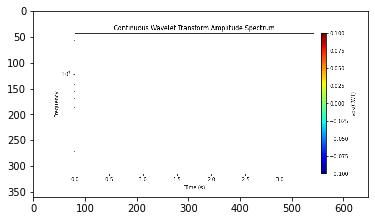

(360, 648, 4)
a0027_34156_N.tiff


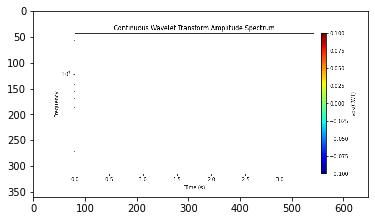

(360, 648, 4)
a0229_35627_N.tiff


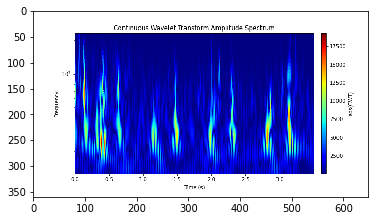

(360, 648, 4)
a0311_17379_N.tiff


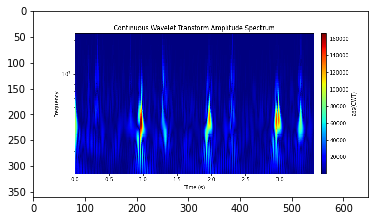

(360, 648, 4)
a0178_30007_N.tiff


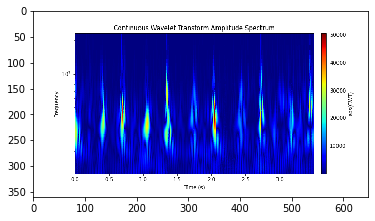

(360, 648, 4)
a0328_49555_N.tiff


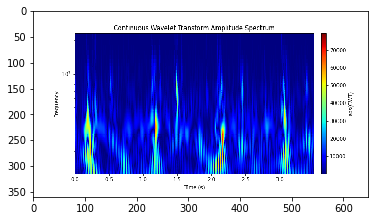

(360, 648, 4)
a0029_7457_N.tiff


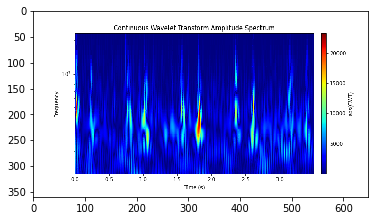

(360, 648, 4)
a0310_31839_N.tiff


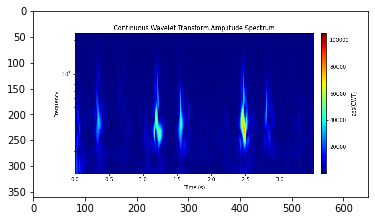

(360, 648, 4)
a0328_31535_N.tiff


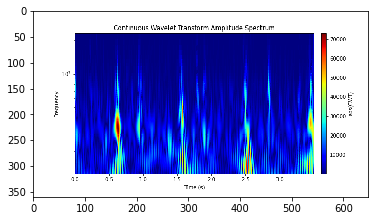

(360, 648, 4)
a0105_510_N.tiff


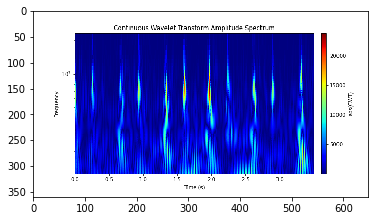

(360, 648, 4)
a0106_15044_N.tiff


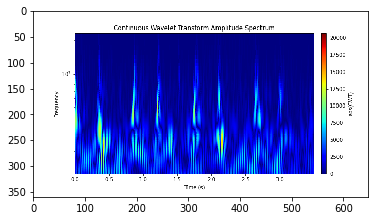

(360, 648, 4)


In [11]:
import os
img_names= os.listdir(train_data_dir[1]+'0')
for i in range(len(img_names)):
    img=img_names[i]
    print(img)
    read=plt.imread(train_data_dir[0]+'0/'+img)
    plt.imshow(read)
    plt.show()
    print(read.shape)
    
    if i==10:
        break

In [15]:
k1,k2 = 272, 462
s_x = 82;
e_x = 544;
s_y = 43;
e_y = 315;


batch_size=PARAMS['batch_size']

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split

def cropper(img):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    #print(img.shape)
    #plt.figure()
    #wplt.imshow(img[s_y:e_y,s_x:e_x])
    return img[s_y:e_y,s_x:e_x]


def generate_generator_multiple(generator,dir1, dir2, batch_size,subset):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size=(360, 648),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          subset=subset,
                                          shuffle=False, 
                                          seed=7)
    
    genX2 = generator.flow_from_directory(dir2,
                                          target_size=(360, 648),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          subset=subset,
                                          shuffle=False, 
                                          seed=7)
    while True:
            X1i, y1i = genX1.next()
            X2i, y2i = genX2.next()
            X1i_cropped = np.zeros((X1i.shape[0], k1, k2, 3))
            X2i_cropped = np.zeros((X2i.shape[0], k1, k2, 3))
            
            for i in range(X1i.shape[0]):      
                X1i_cropped[i] = cropper(X1i[i])
            for i in range(X2i.shape[0]):      
                X2i_cropped[i] = cropper(X2i[i])
                
            yield [[X1i_cropped, X2i_cropped], y1i]  #Yield both images and their mutual label
            
            
dual_training   = generate_generator_multiple(train_datagen,train_data_dir[0],train_data_dir[1],batch_size,'training')
dual_validation = generate_generator_multiple(train_datagen,train_data_dir[0],train_data_dir[1],batch_size,'validation')

Found 2254 images belonging to 2 classes.
Found 2254 images belonging to 2 classes.
2
(20, 272, 462, 3) (20, 272, 462, 3) (20, 2)


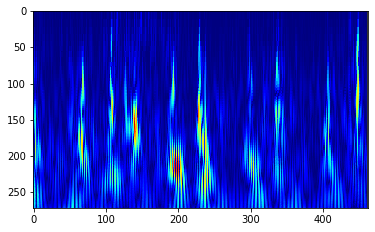

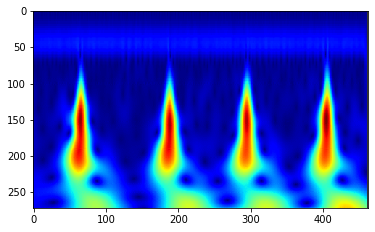

In [16]:
for X in dual_training:
    print(len(X))
    print(X[0][0].shape,X[0][1].shape, X[1].shape)
    
    plt.imshow(X[0][0][0])
    plt.show()
    
    plt.imshow(X[0][1][0])
    plt.show()
    
    break

In [17]:
dual_training_cropped   = crop_generator(dual_training)
dual_validation_cropped = crop_generator(dual_validation)

In [18]:

neptune.init('icassp/Hybrid',NEPTUNE_API_TOKEN)
exp = neptune.create_experiment(name='CNN_hybrid_transfer_learning_BestF1',description='#S2 ICASSP Fixed 252,241 confusion , normalized input , new dataset',params=PARAMS,upload_source_files=['CNN_hybrid_transfer_learning_BestF1.ipynb'],tags=['HS','ECG','ICASSP'],upload_stdout=True)


NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/icassp/Hybrid/e/HYBRID-89


In [19]:
PARAMS['batch_size']

20

In [20]:
exp

Experiment(HYBRID-89)

In [21]:
model = tf.keras.models.load_model('/home/ubuntu/intelliscope/notebooks/physionet2016/pcg/models/Experiment(PCG-50).h5')
#c = model.get_layer('conv2d_3').output
#c = tf.reshape(c, [-1,5, 15,64]) 
#model.summary()
HS_MODEL= tf.keras.Model(inputs=model.input, outputs=model.get_layer('flatten_1').output)
HS_MODEL.trainable=True
HS_MODEL.summary()

model2 = tf.keras.models.load_model('/home/ubuntu/intelliscope/notebooks/physionet2017/ecg/models/Experiment(ECG-24).h5')

#model.summary()

ECG_MODEL= tf.keras.Model(inputs=model2.input, outputs=model2.get_layer('flatten').output)
ECG_MODEL.trainable=True
print("ECG")
ECG_MODEL.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  [(None, 272, 462, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 272, 462, 4)       592       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 154, 4)        0         
_________________________________________________________________
instance_normalization_4 (In (None, 90, 154, 4)        8         
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 154, 4)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 84, 148, 16)       3152      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 49, 16)        0     

In [22]:
'''
def create_convolution_layers(input_img):
    
    conv2d = tf.keras.layers.Conv2D(4, kernel_size=(7,7), padding='same', activation='relu', input_shape=(272,462,m))(input_img)
    max_pooling2d = tf.keras.layers.MaxPool2D(pool_size=(3,3))(conv2d)
    #model = tf.keras.layers.Conv2D(16, kernel_size=(7,7), activation='relu')(max_pooling2d)
    conv2d_1 = tf.keras.layers.Conv2D(16, kernel_size=(7,7), activation='relu',kernel_regularizer=regularizers.l2(0.001))(max_pooling2d)
    max_pooling2d_1  = tf.keras.layers.MaxPool2D(pool_size=(3,3))(conv2d_1)
    model =     tf.keras.layers.Conv2D(32, kernel_size=(7,7), activation='relu',kernel_regularizer=regularizers.l2(0.001))(max_pooling2d_1)

    return model
    
'''

"\ndef create_convolution_layers(input_img):\n    \n    conv2d = tf.keras.layers.Conv2D(4, kernel_size=(7,7), padding='same', activation='relu', input_shape=(272,462,m))(input_img)\n    max_pooling2d = tf.keras.layers.MaxPool2D(pool_size=(3,3))(conv2d)\n    #model = tf.keras.layers.Conv2D(16, kernel_size=(7,7), activation='relu')(max_pooling2d)\n    conv2d_1 = tf.keras.layers.Conv2D(16, kernel_size=(7,7), activation='relu',kernel_regularizer=regularizers.l2(0.001))(max_pooling2d)\n    max_pooling2d_1  = tf.keras.layers.MaxPool2D(pool_size=(3,3))(conv2d_1)\n    model =     tf.keras.layers.Conv2D(32, kernel_size=(7,7), activation='relu',kernel_regularizer=regularizers.l2(0.001))(max_pooling2d_1)\n\n    return model\n    \n"

In [23]:
hs_input = tf.keras.layers.Input(shape=(272,462,m))
hs_model = HS_MODEL(hs_input)
ecg_input = tf.keras.layers.Input(shape=(272,462,m))
ecg_model = ECG_MODEL(ecg_input)

print(ecg_model.get_shape())
print(hs_model.get_shape())

(None, 3840)
(None, 3840)


In [24]:
#hs_model_ = tf.keras.layers.LayerNormalization()(hs_model)
#ecg_model_ = tf.keras.layers.LayerNormalization()(ecg_model)

concat     = tf.keras.layers.concatenate([hs_model, ecg_model])


#batchnorm  = tf.keras.layers.BatchNormalization()(concat)
#dense      = tf.keras.layers.Dense(80, activation='relu')(batchnorm)


dropout    = tf.keras.layers.Dropout(PARAMS['dropout'])(concat)
dense      = tf.keras.layers.Dense(PARAMS['dense_layers'], activation='relu')(dropout)

dense_1    = tf.keras.layers.Dense(20, activation='relu')(dense)
output = tf.keras.layers.Dense(2, activation='softmax')(dense_1)

model = tf.keras.Model(inputs=[hs_input, ecg_input], outputs=[output])


model.compile(optimizer=keras.optimizers.Adam(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.CategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 272, 462, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 272, 462, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 3840)         47592       input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 3840)         47592       input_2[0][0]                    
____________________________________________________________________________________________

In [25]:

model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))

In [26]:
model.fit_generator(
    dual_training,
    steps_per_epoch = 1803 // batch_size,
    validation_data = dual_validation,
    validation_steps = 451 // batch_size,
    epochs =PARAMS['epochs'])

'''
callbacks=[
                tf.keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: log_epoch_data(logs, exp)),
]
'''

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


NotImplementedError: in converted code:

    /home/ubuntu/core-env/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/ubuntu/core-env/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /home/ubuntu/core-env/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_utils.py:513 standardize_input_data
        data = [np.asarray(d) for d in data]
    /home/ubuntu/core-env/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_utils.py:513 <listcomp>
        data = [np.asarray(d) for d in data]
    /home/ubuntu/core-env/lib/python3.6/site-packages/numpy/core/_asarray.py:85 asarray
        return array(a, dtype, copy=False, order=order)
    /home/ubuntu/core-env/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:728 __array__
        " array.".format(self.name))

    NotImplementedError: Cannot convert a symbolic Tensor (args_2:0) to a numpy array.


In [24]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 272, 462, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 270, 556, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 3840)         47360       input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4800)         47360       input_2[0][0]                    
____________________________________________________________________________________________

In [25]:
len(y_train[y_train==0])/len(y_train)

0.29334916864608074

In [26]:
len(y_test[y_test==1])/len(y_test)

0.7025316455696202

In [27]:
print(num_classes)

2


In [28]:
x_train1.shape

(2526, 272, 462, 3)

In [29]:
resized_x_train2.shape

(2526, 270, 556, 3)

In [30]:
history = model.fit([x_train1,resized_x_train2], y_train,  batch_size=PARAMS['batch_size'], validation_split=PARAMS['validation_split'],epochs=PARAMS['epochs'],callbacks=[
                tf.keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: log_epoch_data(logs, exp)),
])

Train on 2020 samples, validate on 506 samples
Epoch 1/15
2020/2020 [==============================] - 48s 24ms/sample - loss: 0.6024 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.6324
Epoch 2/15
2020/2020 [==============================] - 46s 23ms/sample - loss: 0.4877 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.7471 - val_sparse_categorical_accuracy: 0.6423
Epoch 3/15
2020/2020 [==============================] - 47s 23ms/sample - loss: 0.4128 - sparse_categorical_accuracy: 0.8208 - val_loss: 0.9390 - val_sparse_categorical_accuracy: 0.6186
Epoch 4/15
2020/2020 [==============================] - 47s 23ms/sample - loss: 0.3390 - sparse_categorical_accuracy: 0.8564 - val_loss: 0.8643 - val_sparse_categorical_accuracy: 0.6225
Epoch 5/15
2020/2020 [==============================] - 47s 23ms/sample - loss: 0.2594 - sparse_categorical_accuracy: 0.8995 - val_loss: 0.8332 - val_sparse_categorical_accuracy: 0.6383
Epoch 6/15
2020/2020 [=

In [31]:
x_test1 = x_test[:,:,:,0:m]
x_test2 = x_test[:,:,:,m:e]

In [32]:
x_test1 = x_test1.reshape((len(x_test),272,462,m))
x_test2 = x_test2.reshape((len(x_test),272,462,m))#ECGGGGG 

resized_x_test2 = np.zeros((len(x_test),270,556,m))


for i in range(0,len(x_test)):
    resized_x_test2[i] = cv.resize(x_test2[i], (556,270), interpolation = cv.INTER_AREA)


In [33]:
score = model.evaluate([x_test1,resized_x_test2],  y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


print('\nHistory dict:', history.history)

632/632 - 5s - loss: 3.0595 - sparse_categorical_accuracy: 0.6851
Test loss: 3.059508291792266
Test accuracy: 0.6851266

History dict: {'loss': [0.602448434817909, 0.48765335859048486, 0.4127806785083053, 0.33898517459926036, 0.2594086775685301, 0.16355294372775767, 0.11174416470129302, 0.08086797207741454, 0.04864106903608778, 0.036229311774420264, 0.08735422541083086, 0.09263128187913115, 0.046632019480192424, 0.017484557160204, 0.015316404337708903], 'sparse_categorical_accuracy': [0.71831685, 0.7861386, 0.8207921, 0.85643566, 0.89950496, 0.94455445, 0.9643564, 0.97970295, 0.990099, 0.9930693, 0.97821784, 0.97128713, 0.9905941, 1.0, 1.0], 'val_loss': [0.7461322065398627, 0.7470854860049463, 0.9390049576759338, 0.8643317318009764, 0.8332380704257799, 1.2161007417520515, 1.6183742572196387, 1.6068446475997744, 2.531974446160991, 1.9755095921957446, 1.7937261549380457, 2.1009597955013923, 2.514309461880107, 2.68976758402798, 2.839933574906451], 'val_sparse_categorical_accuracy': [0.632

632/632 - 5s - loss: 3.0595 - sparse_categorical_accuracy: 0.6851


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


0.6851266


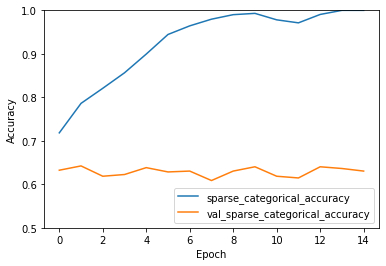

In [34]:
fig = plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate([x_test1,resized_x_test2],  y_test, verbose=2)

fig.canvas.draw()
curve = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
curve = curve.reshape(fig.canvas.get_width_height()[::-1] + (3,))

neptune.log_image('learning_curve', curve)
neptune.log_metric('Test Accuracy',test_acc)
neptune.log_metric('Test Loss',test_loss)
print(test_acc)

In [35]:

loss, acc = model.evaluate([x_test1,resized_x_test2],  y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

632/632 - 5s - loss: 3.0595 - sparse_categorical_accuracy: 0.6851
Restored model, accuracy: 68.51%


In [36]:
keras_model_path = "/home/ec2-user/SageMaker/notebooks_ramith/out/"  + str(exp) + '.h5'  

model.save(keras_model_path)  # save() should be called out of strategy scope

neptune.log_artifact(keras_model_path)


In [37]:
from sklearn.metrics import classification_report

y_pred = model.predict([x_test1,resized_x_test2], batch_size=100, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

z = classification_report(y_test, y_pred_bool)
print(z)

neptune.log_text('classification_report', z)

632/632 [==============================] - 6s 9ms/sample
              precision    recall  f1-score   support

           0       0.42      0.15      0.23       188
           1       0.72      0.91      0.80       444

    accuracy                           0.69       632
   macro avg       0.57      0.53      0.51       632
weighted avg       0.63      0.69      0.63       632



In [40]:
#!pip install neptune-contrib

In [45]:
!pip install scikit-plot -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [46]:
from neptunecontrib.monitoring.metrics import *

threshold = 0.5

log_confusion_matrix(y_test, y_pred[:, 1] > threshold)
log_classification_report(y_test, y_pred[:, 1] > threshold)
log_class_metrics(y_test, y_pred[:, 1] > threshold)
log_class_metrics_by_threshold(y_test, y_pred[:, 1])
log_roc_auc(y_test, y_pred)
log_precision_recall_auc(y_test, y_pred)
log_brier_loss(y_test, y_pred[:, 1])
log_log_loss(y_test, y_pred)
log_ks_statistic(y_test, y_pred)
log_cumulative_gain(y_test, y_pred)
log_lift_curve(y_test, y_pred)
log_prediction_distribution(y_test, y_pred[:, 1])

In [47]:

neptune.stop()

#### 